# DL1 Assignment2 - Q1.1 draft code

This is a small help from us to save you some coding. This notebook is **not** graded, you are free to edit it.

Further advise:
1. Start with File/Save a copy in Drive
2. Set GPU usage under Runtime/Change runtime type/Hardware accelerator.

In [1]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.9 MB/s eta 0:00:00


In [2]:
import torch
from torch import nn
import timm
from torchvision import models
from matplotlib import pyplot as plt
from typing import Callable

%matplotlib inline

In [10]:
def vit_s_8():
    """ViT-S/8 is not a default torchvision model, so we provide it by timm"""
    # Accuracy approximation comes from
    # https://openreview.net/pdf?id=LtKcMgGOeLt
    # and DINO
    # https://arxiv.org/abs/2104.14294
    return timm.create_model('vit_small_patch8_224')

# Model definitions
# Optional Q: These are uncalled functions. What do you think would happen
# if we called all of them once? Why didn't we do that?
model_defs = [
    vit_s_8,
    models.vit_b_32,
    models.vgg11,
    models.vgg11_bn,
    models.resnet18,
    models.densenet121,
    models.mobilenet_v3_small,
]

# Accuracies per model
model_accs = {
    'vit_s_8': 80., # Approximated
    'vit_b_32' : 75.912,
    'vgg11' : 69.02,
    'vgg11_bn' : 70.37,
    'resnet18' : 69.758,
    'densenet121' : 74.434,
    'mobilenet_v3_small' : 67.668,
}


def measure_runtime_per_forward(model:nn.Module, no_grad:bool, batch_size:int=8):
    """Measures the time for a single pass in milliseconds"""

    # Generate fake RGB input (224x224)
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    inp = torch.rand(batch_size,3,224,224)
    #######################
    # END OF YOUR CODE    #
    #######################

    start = torch.cuda.Event(enable_timing=True)
    end = torch.cuda.Event(enable_timing=True)
    start.record()

    # Run the model
    #######################
    # PUT YOUR CODE HERE  #
    #######################
    inp = inp.to("cuda")
    if no_grad:
      with torch.no_grad():
        model(inp)
    else:
      model(inp)
    #######################
    # END OF YOUR CODE    #
    #######################

    end.record()
    torch.cuda.synchronize()
    return start.elapsed_time(end)


def evaluate_model(model_def:Callable, no_grad:bool, batch_size:int=8):

    # Retreive initial memory allocation
    initial_vram = torch.cuda.memory_allocated()

    # Define model
    model = model_def().cuda().eval()
    # Access name as: model.__name__

    # Parameters that need to be filled
    n_params = 0
    times, vrams = [], []
    mean_time = None
    mean_vram = None

    #######################
    # PUT YOUR CODE HERE  #
    #######################
    # Step 1: Calculate the number of **trainable** parameters
    # Step 2: Warm up with a few passes
    # Step 3: Run N forward passes and save the runtime +
    #         the vram allocated by the model
    # Step 4: Take the mean, preferably with dropping possible outliers
    for parameter in model.parameters():
      if parameter.requires_grad:
        n_params += parameter.numel()

    for _ in range(5):
      measure_runtime_per_forward(model, no_grad, batch_size)

    N_runs = 10
    for _ in range(N_runs):
      times.append(measure_runtime_per_forward(model, no_grad, batch_size))
      vrams.append(torch.cuda.memory_allocated("cuda")/(1024**2))

    mean_time = sum(times)/N_runs
    mean_vram = sum(vrams)/N_runs
    #######################
    # END OF YOUR CODE    #
    #######################

    # Clean up space for the model
    del model
    torch.cuda.empty_cache()

    return mean_time, mean_vram, n_params


Assignment 1a:


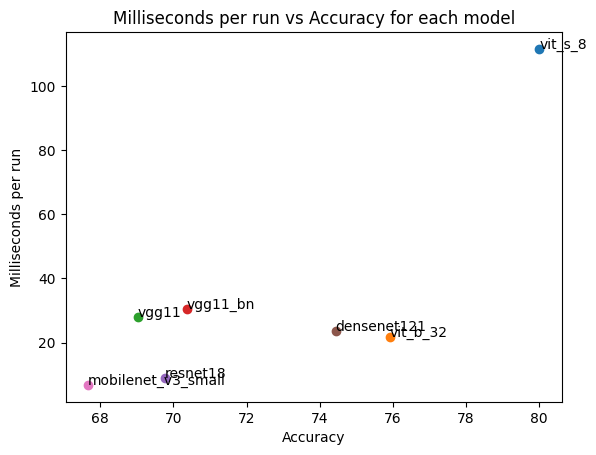

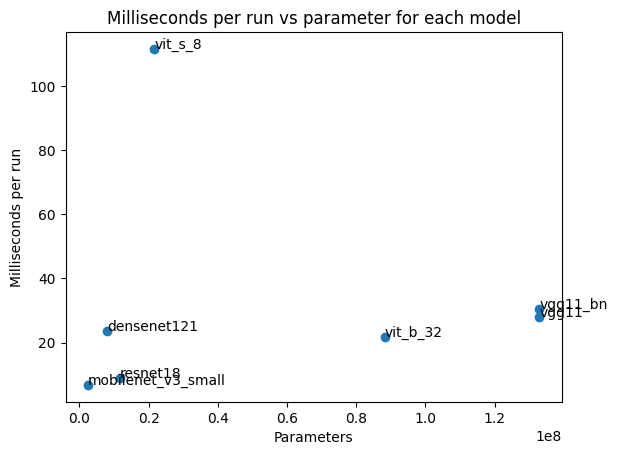

Assignment 1b:


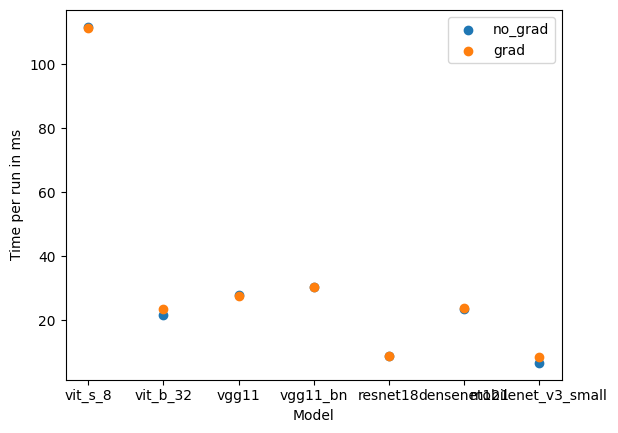

Assignment 1c:
[102.759375, 345.298828125, 522.683984375, 519.055859375, 52.8154296875, 50.00888671875, 17.93017578125]


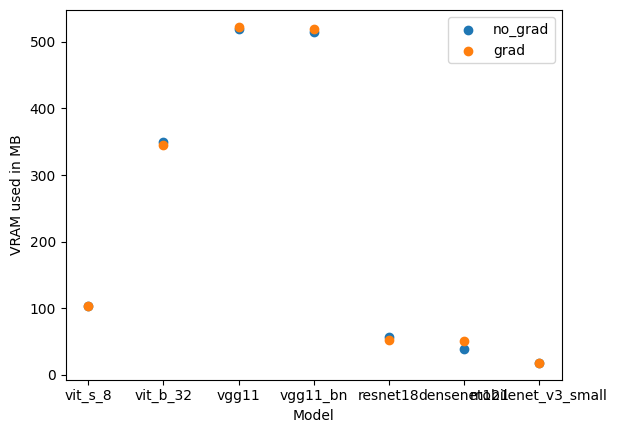

In [5]:
#######################
# PUT YOUR CODE HERE  #
#######################

# Make your plots here with matplotlib
#
# Example usage of the above functions:
# for model_def in model_defs:
#     name = model_def.__name__
#     time, vram, n_params = evaluate_model(model_def, no_grad=True)
#     print(name, time, vram, n_params)
model_times = []
model_names = []
model_vrams = []
model_params = []
for model_def in model_defs:
     name = model_def.__name__
     time, _, n_params = evaluate_model(model_def, no_grad=True)
     model_times.append(time)
     model_names.append(name)
     model_params.append(n_params)

print("Assignment 1a:")
for name,y in zip(model_names, model_times):
  x = model_accs[name]
  plt.scatter(x,y)
  plt.annotate(name, (x,y))
plt.xlabel("Accuracy")
plt.ylabel("Milliseconds per run")
plt.title("Milliseconds per run vs Accuracy for each model")
plt.show()

plt.scatter(model_params, model_times)
for name,x,y in zip(model_names, model_params, model_times):
  plt.annotate(name, (x,y))
plt.xlabel("Parameters")
plt.ylabel("Milliseconds per run")
plt.title("Milliseconds per run vs parameter for each model")
plt.show()

print("Assignment 1b:")
model_grad_times = []
model_grad_vram = []
for model_def in model_defs:
  time, _, _ = evaluate_model(model_def, no_grad=False)
  model_grad_times.append(time)

plt.scatter(model_names, model_times, label="no_grad")
plt.scatter(model_names, model_grad_times, label="grad")
plt.xlabel("Model")
plt.ylabel("Time per run in ms")
plt.legend()
plt.show()

print("Assignment 1c:")
for model_def in model_defs:
  _, vram, _ = evaluate_model(model_def, no_grad=True, batch_size = 64)
  model_vrams.append(vram)

  _, vram, _ = evaluate_model(model_def, no_grad=False, batch_size = 64)
  model_grad_vram.append(vram)

plt.scatter(model_names, model_vrams, label="no_grad")
plt.scatter(model_names, model_grad_vram, label="grad")
plt.xlabel("Model")
plt.ylabel("VRAM used in MB")
plt.legend()
plt.show()

#######################
# END OF YOUR CODE    #
#######################